In [1]:
from scipy.io import savemat
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import pyvista as pv
from tqdm import tqdm, trange
import time
import numexpr as ne
import fast_simplification
import numpy as np

In [2]:
def scattering_function_tetrahedron(verts, tetrahedra, q_grid):
    """
    Evaluate the scattering function of the whole mesh over a grid of wave vectors for tetrahedra.
    
    Parameters:
    vertices (numpy.ndarray): Array of shape (n, 3) containing the vertices of the mesh.
    tetrahedra (numpy.ndarray): Array of shape (m, 4) containing the indices of the vertices forming each tetrahedron.
    q_grid (list): List of 3 numpy arrays representing the grid of wave vectors.
    
    Returns:
    numpy.ndarray: The scattering function values over the grid.
    """
    print("Flattening q_grid...")
    start_time = time.time()
    q_grid_flat = np.array([q_grid[0].flatten(), q_grid[1].flatten(), q_grid[2].flatten()])
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating tetrahedron volumes...")
    start_time = time.time()
    r0 = verts[tetrahedra[:, 0]]
    r1 = verts[tetrahedra[:, 1]]
    r2 = verts[tetrahedra[:, 2]]
    r3 = verts[tetrahedra[:, 3]]
    volumes = np.abs(np.einsum('ij,ij->i', np.cross(r0 - r1, r0 - r2), r0 - r3)) / 6
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating q_dot_r for all vertices...")
    start_time = time.time()
    q_dot_r_all = verts @ q_grid_flat
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating q_dot_r for all tetrahedra...")
    start_time = time.time()
    q_dot_r_tetrahedra = q_dot_r_all[tetrahedra] # (m, 4, nq)
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating (qri - qrj), etc...")
    start_time = time.time()
    qr0 = q_dot_r_tetrahedra[:, 0, :]
    qr1 = q_dot_r_tetrahedra[:, 1, :]
    qr2 = q_dot_r_tetrahedra[:, 2, :]
    qr3 = q_dot_r_tetrahedra[:, 3, :]
    qr0_minus_qr1 = qr0 - qr1
    qr0_minus_qr2 = qr0 - qr2
    qr0_minus_qr3 = qr0 - qr3
    qr1_minus_qr2 = qr1 - qr2
    qr1_minus_qr3 = qr1 - qr3
    qr2_minus_qr3 = qr2 - qr3
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating exp_i_(qri), etc...")
    start_time = time.time()
    exp_i_qr0 = np.exp(1j * qr0)
    exp_i_qr1 = np.exp(1j * qr1)
    exp_i_qr2 = np.exp(1j * qr2)
    exp_i_qr3 = np.exp(1j * qr3)
    print(f"Time taken: {time.time() - start_time} seconds")
  
    print("Calculating Numerator...")
    Numerator0 = -exp_i_qr0*qr1_minus_qr2*qr1_minus_qr3*qr2_minus_qr3
    Numerator1 = exp_i_qr1*qr0_minus_qr2*qr0_minus_qr3*qr2_minus_qr3
    Numerator2 = exp_i_qr2*qr0_minus_qr1*qr0_minus_qr3*qr1_minus_qr3
    Numerator3 = -exp_i_qr3*qr0_minus_qr1*qr0_minus_qr2*qr1_minus_qr2
    Numerator = Numerator0 + Numerator1 + Numerator2 + Numerator3
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Calculating Denominator...")
    Denominator01 = qr0_minus_qr1
    Denominator02 = qr0_minus_qr2
    Denominator03 = qr0_minus_qr3
    Denominator12 = qr1_minus_qr2
    Denominator13 = qr1_minus_qr3
    Denominator23 = qr2_minus_qr3
    Denominator01[Denominator01 == 0] = 1
    Denominator02[Denominator02 == 0] = 1
    Denominator03[Denominator03 == 0] = 1
    Denominator12[Denominator12 == 0] = 1
    Denominator13[Denominator13 == 0] = 1
    Denominator23[Denominator23 == 0] = 1
    Denominator = Denominator01 * Denominator02 * Denominator03 * Denominator12 * Denominator13 * Denominator23 * (1j)**3
    print(f"Time taken: {time.time() - start_time} seconds")

    
    print("Calculating F_q...")
    start_time = time.time()
    volumes_expanded = np.repeat(volumes[:, np.newaxis], q_dot_r_tetrahedra.shape[2], axis=1)
    F_q_tetrahedra = ne.evaluate("volumes_expanded * Numerator / Denominator")
    F_q = np.sum(F_q_tetrahedra, axis=0)
    print(f"Time taken: {time.time() - start_time} seconds")

    print("Calculating scattering function I_q...")
    start_time = time.time()
    I_q = np.abs(F_q) ** 2
    print(f"Time taken: {time.time() - start_time} seconds")
    
    print("Scattering function calculation complete.")
    return I_q

## Generate regular polynedron pillar

In [3]:
# We consider particles having the shape of a right prism of length L and a cross-section made of a regular polygon with n sides
def generate_prism(n, R, AR, center = (0, 0, 0)):
    """
    Generate vertices and faces for a right prism with a regular polygon base.
    
    Parameters:
    n (int): Number of sides of the regular polygon.
    R (float): Radius of circumradius circle of
    AR (float): Aspect ratio of the prism.
    
    Returns:
    tuple: Tuple containing vertices and faces of the prism.
    """
    # Calculate the area of the base polygon
    r = R/2/np.pi
    A = 0.5 * n * r**2 * np.sin(2*np.pi/n)
    
    # Calculate the R_ave of the base polygon
    R_ave = np.sqrt(A/np.pi)
    
    # Calculate the length of the prism
    L = AR * R_ave*2
    
    
    # Generate the vertices of the base polygon
    theta = np.linspace(0, 2 * np.pi, n, endpoint=False) + 1e-6
    x = np.cos(theta)*r
    y = np.sin(theta)*r
    z = np.zeros_like(x)
    
    # Vertices of the top and bottom faces
    vertices = np.vstack((np.column_stack((x, y, z)), np.column_stack((x, y, z + L))))
    
    # # Generate the faces
    # faces = []
    # for i in range(n):
    #     next_i = (i + 1) % n
    #     # Bottom face
    #     faces.append([i, next_i, next_i + n, i + n])
    #     # Top face
    #     faces.append([i, next_i, next_i + n, i + n])
    
    return vertices

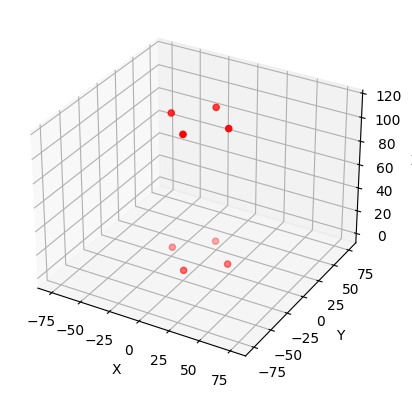

In [4]:
# Generate the vertices and faces of the prism
n = 4
R = 150
AR = 3
vertices = generate_prism(n, R, AR)
L = np.max(vertices[:, 2]) - np.min(vertices[:, 2])
# v_bottom = np.array([0, 0, 0])
# v_top = np.array([0, 0, L])
# vertices = np.vstack((vertices, v_top, v_bottom))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z coordinates of vertices
x = vertices[:, 0]
y = vertices[:, 1]
z = vertices[:, 2]

# Plot the vertices
ax.scatter(x, y, z, c='r', marker='o')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_aspect('equal')

plt.show()

0, 1
1, 2
2, 3
3, 0


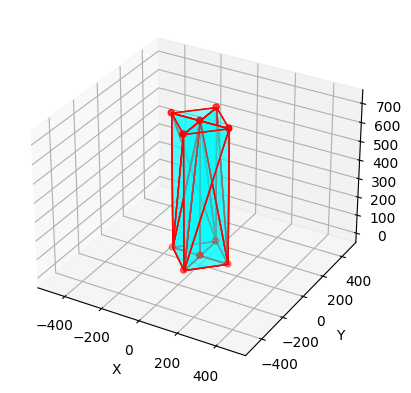

In [5]:
verts = generate_prism(n, R, AR)
L = np.max(vertices[:, 2]) - np.min(vertices[:, 2])
v_bottom = np.array([0, 0, 0])
v_top = np.array([0, 0, L])
verts = np.vstack((verts, v_bottom, v_top))*2*np.pi

# generate the vertices of the tertrahedra
tetrahedra = []
for i in range(n):
    next_i = (i + 1) % n
    print(f"{i}, {next_i}")
    tri_prism = [2*n, i, next_i, 2*n+1, i+n, next_i+n]
    # tri_prism = [0,1,2,3,4,5]
    tetrahedra.append([tri_prism[0], tri_prism[1], tri_prism[2], tri_prism[3]])
    tetrahedra.append([tri_prism[1], tri_prism[3], tri_prism[4], tri_prism[5]])
    tetrahedra.append([tri_prism[1], tri_prism[2], tri_prism[3], tri_prism[5]])
    
tetrahedra = np.array(tetrahedra)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i, tetra in enumerate(tetrahedra):
    color = 'cyan'
    for face in [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]:
        verts_face = verts[tetra[face]]
        ax.add_collection3d(Poly3DCollection([verts_face], facecolors=color, linewidths=1, edgecolors='r', alpha=.25))

# Extract x, y, z coordinates of vertices
x = verts[:, 0]
y = verts[:, 1]
z = verts[:, 2]

# Plot the vertices
ax.scatter(x, y, z, c='r', marker='o')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_aspect('equal')

plt.show()

In [6]:
qx = np.linspace(-1, 1, 500)*0.1
qy = np.linspace(-1, 1, 500)*0.1
qz = 0

q_grid = np.meshgrid(qx, qy, qz)
# q_grid_flat = np.array([q_grid[0].flatten(), q_grid[1].flatten(), q_grid[2].flatten()])
I_q_grid_flat = scattering_function_tetrahedron(verts, tetrahedra, q_grid)
I_q = I_q_grid_flat.reshape(q_grid[0].shape)

Flattening q_grid...
Time taken: 0.005467653274536133 seconds
Calculating tetrahedron volumes...
Time taken: 0.00016880035400390625 seconds
Calculating q_dot_r for all vertices...
Time taken: 0.008531808853149414 seconds
Calculating q_dot_r for all tetrahedra...
Time taken: 0.031650543212890625 seconds
Calculating (qri - qrj), etc...
Time taken: 0.11855220794677734 seconds
Calculating exp_i_(qri), etc...
Time taken: 0.34551382064819336 seconds
Calculating Numerator...
Time taken: 0.5274238586425781 seconds
Calculating Denominator...
Time taken: 0.5830738544464111 seconds
Calculating F_q...
Time taken: 0.02413654327392578 seconds
Calculating scattering function I_q...
Time taken: 0.0014886856079101562 seconds
Scattering function calculation complete.


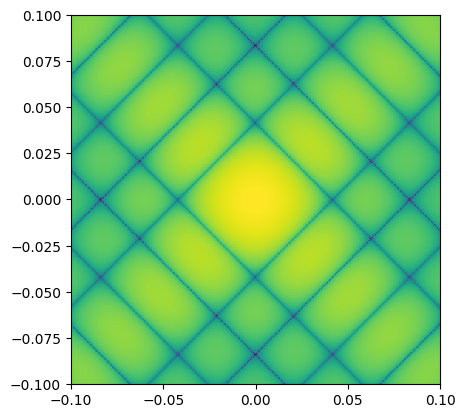

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

# pcolor plot of the scattering function
qx_plot = q_grid[0][:,:, 0]
qy_plot = q_grid[1][:,:, 0]
I_q_plot = I_q[:,:, 0]
ax.pcolor(qx_plot, qy_plot, np.log(I_q_plot), cmap='viridis')

ax.set_aspect('equal')

## for different polygons

In [8]:
def generate_tetrahedra(n, R, AR):
    verts = generate_prism(n, R, AR)
    L = np.max(verts[:, 2]) - np.min(verts[:, 2])
    v_bottom = np.array([0, 0, 0])
    v_top = np.array([0, 0, L])
    verts = np.vstack((verts, v_bottom, v_top)) * 2 * np.pi

    # generate the vertices of the tetrahedra
    tetrahedra = []
    for i in range(n):
        next_i = (i + 1) % n
        tri_prism = [2 * n, i, next_i, 2 * n + 1, i + n, next_i + n]
        tetrahedra.append([tri_prism[0], tri_prism[1], tri_prism[2], tri_prism[3]])
        tetrahedra.append([tri_prism[1], tri_prism[3], tri_prism[4], tri_prism[5]])
        tetrahedra.append([tri_prism[1], tri_prism[2], tri_prism[3], tri_prism[5]])

    tetrahedra = np.array(tetrahedra)
    return verts, tetrahedra

In [ ]:
qx = np.linspace(-1, 1, 400)*0.1
qy = np.linspace(-1, 1, 400)*0.1
qz = 0

q_grid = np.meshgrid(qx, qy, qz)

n_list = [3, 4, 5, 6, 10, 100]
verts, tetrahedra = generate_tetrahedra(4, 150, 3)
for n in n_list:
    verts, tetrahedra = generate_tetrahedra(n, R, AR)
    I_q_grid_flat = scattering_function_tetrahedron(verts, tetrahedra, q_grid)
    I_q = I_q_grid_flat.reshape(q_grid[0].shape)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # pcolor plot of the scattering function
    qx_plot = q_grid[0][:,:, 0]
    qy_plot = q_grid[1][:,:, 0]
    I_q_plot = I_q[:,:, 0]
    ax.pcolor(qx_plot, qy_plot, np.log(I_q_plot), cmap='plasma')
    ax.set_xticks(np.linspace(-0.1, 0.1, 5))
    ax.set_yticks(np.linspace(-0.1, 0.1, 5))
    ax.set_aspect('equal')

Flattening q_grid...
Time taken: 0.0014407634735107422 seconds
Calculating tetrahedron volumes...
Time taken: 0.00012612342834472656 seconds
Calculating q_dot_r for all vertices...
Time taken: 0.0006079673767089844 seconds
Calculating q_dot_r for all tetrahedra...
Time taken: 0.01434779167175293 seconds
Calculating (qri - qrj), etc...
Time taken: 0.08212065696716309 seconds
Calculating exp_i_(qri), etc...
Time taken: 0.1554698944091797 seconds
Calculating Numerator...
Time taken: 0.23413300514221191 seconds
Calculating Denominator...
Time taken: 0.2598392963409424 seconds
Calculating F_q...
Time taken: 0.009468317031860352 seconds
Calculating scattering function I_q...
Time taken: 0.00044727325439453125 seconds
Scattering function calculation complete.
Flattening q_grid...
Time taken: 0.0013644695281982422 seconds
Calculating tetrahedron volumes...
Time taken: 0.0001475811004638672 seconds
Calculating q_dot_r for all vertices...
Time taken: 0.0006909370422363281 seconds
Calculating q_d